# Simulate BGs
* description: simulate bgs given common user input
* version: 0.0.3
* created: 2018-12-15
* author: Ed Nykaza 
* dependencies:
    * requires conda environment (see readme for instructions)
* license: BSD-2-Clause

## General form of simulation equation
Delta BG is the change in blood glucose (BG) with the units: $\frac{(mg/dL)}{5min}$

$\Delta BG[t] = EGP[t]+ \Delta BG_{Carb}[t]+\Delta BG_{Insulin}$

where EGP is the endogenous glucose production, which can be thought of as a surrogate for the basal rate as the purpose of the basal rate is to counter the EGP. Also, given basal rates are givin U/hr, we must divide by 12 to get basalRate in proper units.

### The equation can be expanded to include common insulin pump therapy parameters:

$\Delta BG[t] = ISF \bigg(\frac{BR[t]}{12} + \frac{ACV[t]}{CIR[t]} - AIV[t] \bigg)$

where:

* $ACV[t] = \sum CA[t]*CAC[t]$ <br />
* $AIV[t] = \sum IA[t]*IAC[t]$ <br />
* $ISF$ is the insulin sensitivity factor (mg/dL) / U <br />
* $BR$ is the basal rate U / hr <br />
* $CIR$ is the carb-to-insulin ratio g / U <br />
* $ACV$ is the active carb velocity g / 5min <br />
* $CA$ is each carb amount g  <br />
* $CAC$ is each carb activity curve  1 / 5min  <br />
* $AIV$ is the active insulin velocity U / 5 min <br />
* $IA$ is each insulin amount g  <br />
* $IAC$ is each insulin activity curve  1 / 5min  <br />

## Instructions

Each of these checkboxes refers to a cell in this jupyter notebook. Recall that you press  `shift-return` to execute each cell, or you can press the `Run` button (above)

1. [ ] first load the required libraries
2. [ ] input the situation you want to simulate
    * for the inputs with single values, just input the number or string
    * for the inputs that can change over time:
        * you can add as many rows to the array as needed
        * you can delete rows too if needed
3. [ ] disable auto scrolling
4. [ ] view the data you enter to make sure it is set up as you like 
5. [ ] run the simulation (sorry there is a lot of code here), just scroll to the bottom of the cell to see the output figure

In [1]:
# %% 1. LOAD REQUIRED LIBRARIES
%matplotlib inline
import pdb
import os
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.font_manager as fm
import matplotlib.style as ms
ms.use("default")
import plotly.plotly as py
import plotly.figure_factory as ff

In [2]:
# %% 2. INPUT SETTINGS YOU WANT TO SIMULATE
# currentTime (can take string or date time format)
currentTime = "12:00 PM"  # dt.datetime.now()

# starting BG Level (valid range is 40 to 400 mg/dL)
startingBGLevel = 360

# Insulin Model (4 options)
insulinModel = "adult"  # "adult", "child", "fiasp", or "walsh"

# Insulin Sensitivity Factors (time, isf in [(mg/dL)/U])
isfInputArray = np.array([["12:00 AM", 40],
                          ["12:00 PM", 40],
                          ["4:00 PM", 40],                          
                          ["8:00 PM", 40]])

# Carb-to-Insulin Ratios (time, cir in [g/U])
cirInputArray = np.array([["12:00 AM", 10],
                          ["6:00 AM", 10],
                          ["10:00 AM", 10]])

# Scheduled Basal Rates (time, basalRate [U/hr])
sbrInputArray = np.array([["12:00 AM", 1],
                          ["6:00 AM", 1],
                          ["10:00 AM", 1]])

# Temp Basals & Suspends (time, basalRate [U/hr], duration [min])
# NOTE: basalRate = 0 is a suspend
abrInputArray = np.array([["4:00 AM", 4, 120],
                          ["11:00 AM", 0, 15],
                          ["1:00 PM", 1.5, 60],
                          ["3:00 PM", 0.5, 30]])

# Boluses (time, unitsInsulin [U], carbs [g], carbModel)
# NOTE: carbModel includes the linear models used in the DIY Loop.
# carbModel options include lowGI, medGI, highGI with 2, 3, 4 hours of activity, respectively. 
bolusInputArray = np.array([["9:00 AM", 4, 40, "lowGI"],
                           ["2:00 PM", 2, 20, "lowGI"]])

## 3. Disable Scrolling of Output

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
# %% VIEW THE SETTINGS YOU WANT TO SIMULATE
# create a data table of all inputs (for visualization purposes)
isfDF = pd.DataFrame(isfInputArray, columns=["time", "ISF"])    
cirDF = pd.DataFrame(cirInputArray, columns=["time", "CIR"])        
allSettings = pd.merge(isfDF, cirDF, how="outer", on="time")
sbrDF = pd.DataFrame(sbrInputArray, columns=["time", "BR"])       
abrDF = pd.DataFrame(abrInputArray, columns=["time", "TB", "duration"])     
bolDF = pd.DataFrame(bolusInputArray, columns=["time", "IA", "CA", "carbModel"])
allSettings = pd.merge(allSettings, sbrDF, how="outer", on="time")
allSettings = pd.merge(allSettings, abrDF, how="outer", on="time")
allSettings = pd.merge(allSettings, bolDF, how="outer", on="time")
allSettings["dt"] = pd.to_datetime(allSettings["time"])
allSettings.sort_values("dt", inplace=True)
allSettings.drop(columns="dt", inplace=True)
allSettings["insulinModel"]= insulinModel

# data table of your inputs
# NOTE: if you want a pretty table, uncomment these 2 lines
# table = ff.create_table(allSettings)
# py.iplot(table, filename='all-data-table')
allSettings


,time,ISF,CIR,BR,TB,duration,IA,CA,carbModel,insulinModel
0,12:00 AM,40,10,1,NaN,NaN,NaN,NaN,NaN,adult
6,4:00 AM,NaN,NaN,NaN,4,120,NaN,NaN,NaN,adult
4,6:00 AM,NaN,10,1,NaN,NaN,NaN,NaN,NaN,adult
10,9:00 AM,NaN,NaN,NaN,NaN,NaN,4,40,lowGI,adult
5,10:00 AM,NaN,10,1,NaN,NaN,NaN,NaN,NaN,adult
7,11:00 AM,NaN,NaN,NaN,0,15,NaN,NaN,NaN,adult
1,12:00 PM,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,adult
8,1:00 PM,NaN,NaN,NaN,1.5,60,NaN,NaN,NaN,adult
11,2:00 PM,NaN,NaN,NaN,NaN,NaN,2,20,lowGI,adult
9,3:00 PM,NaN,NaN,NaN,0.5,30,NaN,NaN,NaN,adult


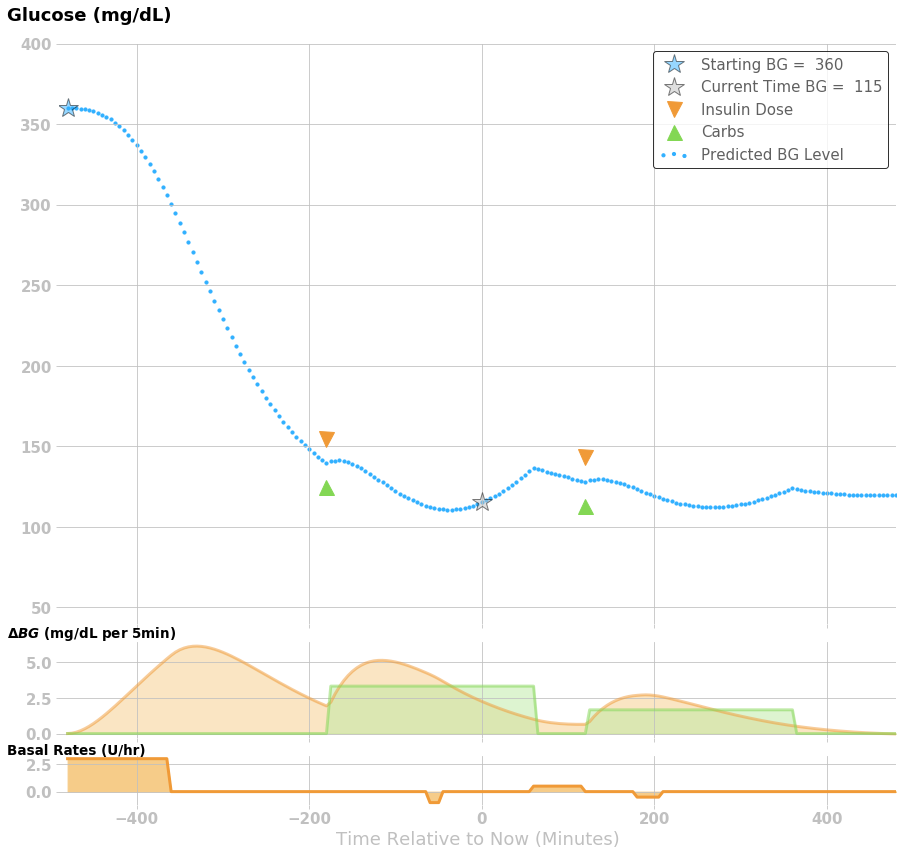

In [14]:
# %% RUN THE SIMULATION (FIGURE BELOW)

# %% FUNCTIONS
def create_deltaBG_functions(deltaBgEquation):

    def get_deltaBG_function(ISF=0, BR=0, TB=0,
                             ACV=0, CIR=1, ABOLV=0,
                             AIV=0, deltaBgEquation=deltaBgEquation):

        return eval(deltaBgEquation)

    return get_deltaBG_function


def expand_settings(userInputArray, settingName, timeStepSize=5):
    # this will be user input (a simple table of the ISF schedule)
    userInputDf = pd.DataFrame(userInputArray,
                               columns=[settingName + ".time", settingName])

    # make sure the values are floats and not integers
    userInputDf[settingName] = userInputDf[settingName].astype("float")

    # expand the data to cover the entire date span
    settingDf = pd.DataFrame()
    for d in [-1, 0, 1]:
        userInputDf["dateTime"] = \
            pd.to_datetime(userInputDf[settingName + ".time"]) + pd.Timedelta(d, unit="D")
        settingDf = pd.concat([settingDf, userInputDf], ignore_index=True)

    # make sure times are rounded to the nearest 5 minutes
    settingDf["dateTime"] = settingDf["dateTime"].dt.round(str(timeStepSize) + "min")

    return settingDf


def merge_and_fill_data(settingDf, df):
    # merge df with the main contiguous 5 minute df frame
    df = pd.merge(df, settingDf, how="left", on="dateTime")
    # fill in the values
    df.fillna(method='ffill', inplace=True)
    return df


def common_figure_elements(ax, xLabel, yLabel, figureFont,
                           xLabelFontSize, yLabelFontSize, tickLabelFontSize,
                           coord_color, yLabel_xOffset=0.4):
    # x-axis items
    ax.set_xlabel(xLabel, fontsize=xLabelFontSize, color=coord_color)

    # define the spines and grid
    ax.spines['bottom'].set_color(coord_color)
    ax.spines['top'].set_color(coord_color)
    ax.spines['left'].set_color(coord_color)
    ax.spines['right'].set_color(coord_color)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(ls='-', color=coord_color)

    # set size of ticklabels
    ax.tick_params(axis='both', labelsize=tickLabelFontSize, colors=coord_color)

    # define labels and limits
    ax.text(min(ax.get_xlim()) - yLabel_xOffset,
            max(ax.get_ylim()) + abs(max(ax.get_ylim()) - min(ax.get_ylim()))/25,
            yLabel, fontproperties=figureFont, size=yLabelFontSize)

    return ax


# %% define the model
deltaBgEquation = "ISF * ((ACV/CIR) - AIV)"
deltaBG = create_deltaBG_functions(deltaBgEquation)


# %% load in activity curve data
insulinActivityCurves = pd.read_csv("all-iac-models.csv", low_memory=False)
carbActivityCurves = pd.read_csv("all-cac-models.csv", low_memory=False)
insulinActivityCurve = insulinActivityCurves[insulinModel].values


# %% first create a continuguous time series
currentTime = pd.to_datetime(currentTime)
timeStepSize = 5  # minutes
effectLength = 8  # hours, the display with be +/- this length
timeSeriesLength = effectLength * 3  # hours
roundedCurrentTime = pd.to_datetime(currentTime).round(str(timeStepSize) + "min")
startTime = roundedCurrentTime + pd.Timedelta(-timeSeriesLength, unit="h")
endTime = roundedCurrentTime + pd.Timedelta(timeSeriesLength, unit="h")
rng = pd.date_range(startTime, endTime, freq=(str(timeStepSize) + "min"))
data = pd.DataFrame(rng, columns=["dateTime"])
# create an initial time series that is 3 times the length of simulation plot
data["minutesRelativeToNow"] = np.arange(-timeSeriesLength*60,
                                         timeSeriesLength*60 + timeStepSize,
                                         timeStepSize)

# % ISF
isf = expand_settings(isfInputArray, "isf")
data = merge_and_fill_data(isf, data)

# % CIR
cir = expand_settings(cirInputArray, "cir")
data = merge_and_fill_data(cir, data)

# % SCHEDULED BASAL RATES (SBR)
sbr = expand_settings(sbrInputArray, "sbr")
data = merge_and_fill_data(sbr, data)

# % TEMP BASALS AND SUSPENDS
abrInputDf = pd.DataFrame(abrInputArray, columns=["abr.time", "abr", "duration"])

# make sure the values are floats and not integers
abrInputDf["abr"] = abrInputDf["abr"].astype("float")

# round to the nearest 5 minutes
abrInputDf["dateTime"] = pd.to_datetime(abrInputDf["abr.time"]).dt.round(str(timeStepSize) + "min")

abr = pd.DataFrame()
for b in range(len(abrInputDf)):
    startTime = abrInputDf.loc[b, "dateTime"]
    endTime = startTime + pd.Timedelta(np.int(abrInputDf.loc[b, "duration"]), unit="m")
    rng = pd.date_range(startTime, endTime, freq=(str(timeStepSize) + "min"))
    tempDf = pd.DataFrame(rng[:-1], columns=["dateTime"])
    tempDf["abr"] = abrInputDf.loc[b, "abr"]
    abr = pd.concat([abr, tempDf], ignore_index=True)

# merge data with data df
data = pd.merge(data, abr, how="left", on="dateTime")

# define the effective basal rate (U/hr)
data["ebr"] = (data.abr - data.sbr)
# assume that any basal that is NOT the scheduled basal or suspend is the scheduled basal rate
data["ebr"].fillna(0, inplace=True)
# define the effective basal rate (U/5min)
data["ebi"] = data["ebr"] / 12

# % BOLUSES
boi = pd.DataFrame(bolusInputArray, columns=["boi.time", "boi", "carbInput", "carbModel"])

# make sure the values are floats and not integers
boi["boi"] = boi["boi"].astype("float")
boi["carbInput"] = boi["carbInput"].astype("float")

# round to the nearest 5 minutes
boi["dateTime"] = pd.to_datetime(boi["boi.time"]).dt.round(str(timeStepSize) + "min")

# merge data with data df
data = pd.merge(data, boi, how="left", on="dateTime")
data["boi"].fillna(0, inplace=True)

# % merge basal and bolus insulin amounts together
data["tia"] = data["ebi"] + data["boi"]

# % calculate the insulin activity
data["aiv"] = 0
tempDf = data.loc[data["tia"] != 0, ["tia", "dateTime"]]
for amount, ind in zip(tempDf.tia, tempDf.index):
    aiv = pd.DataFrame(np.array([amount * insulinActivityCurve]).reshape(-1, 1),
                       index=np.arange(ind, (ind + len(insulinActivityCurve))), columns=["aiv"])
    data.loc[ind:(ind + len(insulinActivityCurve)), ["aiv"]] = data["aiv"].add(aiv["aiv"], fill_value=0)

# % calculate the carb activity
data["acv"] = 0
tempDf = data.loc[data["carbInput"] > 0, ["carbInput", "carbModel", "dateTime"]]
for amount, model, ind in zip(tempDf["carbInput"], tempDf["carbModel"], tempDf.index):
    acv = pd.DataFrame(np.array([amount * carbActivityCurves[model]]).reshape(-1, 1),
                       index=np.arange(ind, (ind + len(insulinActivityCurve))), columns=["acv"])
    data.loc[ind:(ind + len(insulinActivityCurve)), ["acv"]] = data["acv"].add(acv["acv"], fill_value=0)

# % window the contiguous data to the effect length
startTime = roundedCurrentTime + pd.Timedelta(-effectLength, unit="h")
endTime = roundedCurrentTime + pd.Timedelta(effectLength, unit="h")
rng = pd.date_range(startTime, endTime, freq=(str(timeStepSize) + "min"))
df = pd.DataFrame(rng, columns=["dateTime"])
df = pd.merge(df, data, how="left", on="dateTime")

# % make the prediction with the new data
df["bg"] = startingBGLevel
df["dBG"] = deltaBG(ISF=df.isf.values,
                    CIR=df.cir.values,
                    ACV=df.acv.values,
                    AIV=df.aiv.values)

df["simulatedBG"] = df["bg"] + df["dBG"].cumsum()
df.loc[df["simulatedBG"] <= 40, "simulatedBG"] = 40
df.loc[df["simulatedBG"] >= 400, "simulatedBG"] = 400


# %% figure stuff
bgRange = [40, 400]

versionNumber = 0
subversion = 4
figureName = currentTime.strftime("%Y-%m-%d-%H-%M") + " Simulate-V" + str(versionNumber) + "-" + str(subversion)
outputPath = os.path.join(".", "figures")

# create output folder if it doesn't exist
if not os.path.isdir(outputPath):
    os.makedirs(outputPath)

figureSizeInches = (15, 7*2)
figureFontNamePath = os.path.join(".", "Roboto-Bold.ttf")
# if the Roboto font exists in specified folder, else use the system default font
if os.path.exists(figureFontNamePath):
    figureFont = fm.FontProperties(fname=figureFontNamePath)
else:
    figureFont = fm.FontProperties()

font = {'weight': 'bold',
        'size': 15}

plt.rc('font', **font)
coord_color = "#c0c0c0"

xLabel = "Time Relative to Now (Minutes)"
yLabel = "Glucose (mg/dL)"
labelFontSize = 18
tickLabelFontSize = 15

# % make the figure
fig = plt.figure(figsize=figureSizeInches)
widths = [1, 1, 1]
heights = [12, 2, 1]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

ax = fig.add_subplot(spec[0, :])
plt.ylim(bgRange)
ax.set_xlim([min(df["minutesRelativeToNow"]) - 10, max(df["minutesRelativeToNow"])])


# plot simulated cgm
ax.scatter(df["minutesRelativeToNow"], df["simulatedBG"], s=10, color="#31B0FF", label="Predicted BG Level")

# plot the starting bg time
ax.plot(df.minutesRelativeToNow[0], startingBGLevel,
        marker='*', markersize=20, color="#31B0FF", markeredgecolor="black", alpha=0.5,
        ls="None", label="Starting BG =  %d" % (round(startingBGLevel)))

# plot the current time
valueCurrentTime = df.loc[df["minutesRelativeToNow"] == 0, "simulatedBG"].values[0]
ax.plot(0, valueCurrentTime,
        marker='*', markersize=20, color=coord_color, markeredgecolor="black", alpha=0.5,
        ls="None", label="Current Time BG =  %d" % (round(valueCurrentTime)))


# run the common figure elements here
ax = common_figure_elements(ax, "", yLabel, figureFont,
                            labelFontSize, labelFontSize, tickLabelFontSize,
                            coord_color, yLabel_xOffset=60)

plt.setp(ax.get_xticklabels(), visible=False)

# add subplot info to the main legend
ax.plot(-1000, -1000, marker='v', markersize=15, color="#f09a37", ls="None", label="Insulin Dose")
ax.plot(-1000, -1000, marker='^', markersize=15, color="#83d754", ls="None", label="Carbs")

# format the legend
leg = ax.legend(scatterpoints=3, edgecolor="black", loc="upper right")
for text in leg.get_texts():
    text.set_color('#606060')
    text.set_weight('normal')

# plot the boluses (do not include in the legend)
boluses = df.loc[pd.notna(df["boi.time"]), ["minutesRelativeToNow", "boi"]]
for bolusIndex in boluses.index:
    ax.plot(df.loc[bolusIndex, "minutesRelativeToNow"],
            df.loc[bolusIndex, "simulatedBG"] + 15,
            marker='v', markersize=15, color="#f09a37",
            ls="None", label="%d Units of Insulin Delivered" % df.loc[bolusIndex, "boi"])

    # plot the carbs
    ax.plot(df.loc[bolusIndex, "minutesRelativeToNow"],
            df.loc[bolusIndex, "simulatedBG"] - 15,
            marker='^', markersize=15,
            color="#83d754", ls="None", label="%d Carbs" % df.loc[bolusIndex, "carbInput"])


# %% plot the scheduled basal rates
ax2 = fig.add_subplot(spec[2, :], sharex=ax)
ax2.plot(df["minutesRelativeToNow"],
        df["ebr"], linestyle="-", color="#f09a37", lw=3, label="Basal Rates (U/hr)")

# fill in temp basals and suspends
ax2.fill_between(df["minutesRelativeToNow"], df["ebr"], color="#f6cc89")

ax2 = common_figure_elements(ax2, xLabel, "Basal Rates (U/hr)", figureFont,
                            labelFontSize, labelFontSize*3/4, tickLabelFontSize,
                            coord_color, yLabel_xOffset=60)

plt.setp(ax2.get_xticklabels(), visible=True)


# %% plot the active effects
ax3 = fig.add_subplot(spec[1, :], sharex=ax)
# plot the active insulin
activeInsulin = df["aiv"]*df["isf"]
ax3.plot(df["minutesRelativeToNow"], activeInsulin,
         linestyle="-", color="#f09a37", 
         lw=3, alpha=0.5, label="Active Insulin (mg/dL per 5min)")

ax3.fill_between(df["minutesRelativeToNow"], activeInsulin, 0, color="#f6cc89", alpha=0.5)

# plot the active carbs
activeCarbs = df["acv"]*df["isf"]/df["cir"]
ax3.plot(df["minutesRelativeToNow"], activeCarbs,
         linestyle="-", color="#83d754",
         lw=3, alpha=0.5, label="Active Carbs (mg/dL per 5min)")

ax3.fill_between(df["minutesRelativeToNow"], activeCarbs, 0, color="#bdeaa3", alpha=0.5)

ax3 = common_figure_elements(ax3, "", "$\Delta BG$ (mg/dL per 5min)", figureFont,
                            labelFontSize, labelFontSize*3/4, tickLabelFontSize,
                            coord_color, yLabel_xOffset=60)
plt.setp(ax3.get_xticklabels(), visible=False)


# save the figure (uncomment these 6 files)
# outputPath = os.path.join(".", "figures")
# create output folder if it doesn't exist
# if not os.path.isdir(outputPath):
#    os.makedirs(outputPath)
# figureName = <ENTER NAME OF FIGURE>
# plt.savefig(os.path.join(outputPath, figureName + ".png"))
plt.subplots_adjust(hspace=0.075)
plt.show()
